In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tqdm.auto import tqdm
from skimage.io import imread
from rl_analysis.plotting import setup_plotting_env, savefig
from skimage import morphology
from skimage import filters
from cellpose import models
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import pandas as pd

In [3]:
# helper functions
def bi_exp_decay(t, A1, K1, A2, K2, C):
    return A1 * np.exp(K1 * t) + A2 * np.exp(K2 * t) + C


def linear_decay(t, M, B):
    return M * t + B


def simple_hampel(trace, win=6, threshold=3):
    use_series = pd.Series(trace)
    meds = use_series.rolling(win, 1, center=True).median()
    mad = lambda x: (x - x.median()).abs().median()
    diffs = use_series.rolling(win, 1, center=True).apply(mad)
    threshold = diffs > threshold
    trace[threshold] = meds[threshold]
    return trace


def lagged_diff(traces, lag, axis=0):
    if axis == 0:
        return traces[lag:] - traces[:-lag]
    else:
        return traces[:, lag:] - traces[:, :-lag]


# we may want to exclude the nucleus...

In [4]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

figure_cfg = analysis_config["figures"]
raw_data = analysis_config["raw_data"]

In [5]:
base_dir = os.path.join(raw_data["hek_cells"], "210716_JM_HEK293T_dLight/")

# Load data and metadata

In [6]:
channels = [0, 0]

In [7]:
model = models.Cellpose(model_type="cyto2", gpu=True)

In [8]:
files = [
    os.path.join(base_dir, "dLight_exp3_20210716_110931_sVG.tif"),
    os.path.join(base_dir, "dLight_exp4_20210716_112801_sVG.tif"),
    os.path.join(base_dir, "dLight_exp5_20210716_114158_sVG.tif"),
]

In [9]:
scale_files = [
    os.path.join(raw_data["hek_cells"], "UFM-L_0.01mm_60X_bin2_20220511_093613.tif")
]

In [10]:
parameters = [
    {"lag": int(5), "trim": np.inf, "start": 5, "onset": 88, "offset": 200},
    {"lag": int(5), "trim": int(135), "start": 5, "onset": 40, "offset": np.inf},
    {"lag": int(5), "trim": int(280), "start": 5, "onset": 50, "offset": 170},
]
hampel_parameters = {"win": 10, "threshold": 2}

In [11]:
from collections import defaultdict


def nested_dict():
    return defaultdict(nested_dict)


results = nested_dict()

In [12]:
baseline_func = bi_exp_decay
baseline_kwargs = {"p0": (0.5, -1e-3, 0.5, -1e-3, 0), "maxfev": int(1e5)}
fallback_func = linear_decay
fallback_kwargs = {"p0": (-0.1, 0), "maxfev": int(1e3)}

In [13]:
from skimage import measure, draw
import tifffile

In [14]:
metadatas = []
for _file in files:
    with tifffile.TiffFile(_file) as t:
        metadatas.append(t.pages[0].description)

In [15]:
scale_dat = imread(scale_files[0])

In [16]:
raw_dat = imread(files[0])

In [17]:
for _file, _parameters in tqdm(zip(files, parameters), total=len(parameters)):
    raw_dat = imread(_file)
    masks, flows, styles, diams = model.eval(
        (np.max(raw_dat[1:50:2], axis=0)),
        diameter=None,
        channels=channels,
        cellprob_threshold=0,
    )

    props = measure.regionprops(masks)

    diameters = np.array([_.major_axis_length for _ in props])
    centroids = np.array([_.centroid for _ in props])

    cells = np.unique(masks)
    cells = cells[cells > 0]
    cells = cells[diameters > 30]
    centroids = centroids[diameters > 30]

    traces_dlight = []
    traces_isos = []
    for _cell, _centroid in zip(cells, centroids):
        rr, cc = draw.disk(_centroid, 7)
        _cell_mask = masks == _cell
        _cell_mask[rr, cc] = 0

        _cell_trace = []
        for _raw_dat in raw_dat:
            _cell_trace.append(_raw_dat[_cell_mask].mean())
        traces_dlight.append(
            simple_hampel(np.array(_cell_trace)[1::2], **hampel_parameters)
        )
        traces_isos.append(
            simple_hampel(np.array(_cell_trace)[::2], **hampel_parameters)
        )

    traces_dlight = np.array(traces_dlight)
    traces_isos = np.array(traces_isos)

    right_edge = int(np.minimum(_parameters["trim"], traces_dlight.shape[1]))
    xvec = np.arange(_parameters["start"], right_edge)
    baseline = np.arange(0, _parameters["onset"] - _parameters["start"])
    if _parameters["offset"] < len(xvec):
        post_stim = np.arange(_parameters["offset"] - _parameters["start"], len(xvec))
        use_region = np.concatenate([baseline, post_stim])
    else:
        use_region = baseline

    trim_traces_dlight = traces_dlight[:, xvec]
    trim_traces_isos = traces_isos[:, xvec]

    traces_dlight_baserem = np.zeros_like(trim_traces_dlight)
    baseline_dlight = np.zeros_like(trim_traces_dlight)

    for i, _trace in tqdm(enumerate(trim_traces_dlight), total=len(trim_traces_dlight)):
        offset = _trace[0]
        try:
            params = curve_fit(
                baseline_func,
                use_region,
                _trace[use_region] - offset,
                **baseline_kwargs
            )
            fit_curve = baseline_func(xvec, *params[0]) + offset
        except:
            params = curve_fit(
                fallback_func,
                use_region,
                _trace[use_region] - offset,
                **fallback_kwargs
            )
            fit_curve = fallback_func(xvec, *params[0]) + offset
        traces_dlight_baserem[i] = (_trace - fit_curve) / fit_curve
        baseline_dlight[i] = fit_curve

    traces_isos_baserem = np.zeros_like(trim_traces_dlight)
    baseline_isos = np.zeros_like(trim_traces_dlight)

    for i, _trace in tqdm(enumerate(trim_traces_isos), total=len(trim_traces_isos)):
        offset = _trace[0]
        try:
            params = curve_fit(
                baseline_func,
                use_region,
                _trace[use_region] - offset,
                **baseline_kwargs
            )
            fit_curve = baseline_func(xvec, *params[0]) + offset
        except:
            params = curve_fit(
                fallback_func,
                use_region,
                _trace[use_region] - offset,
                **fallback_kwargs
            )
            fit_curve = fallback_func(xvec, *params[0]) + offset
        traces_isos_baserem[i] = (_trace - fit_curve) / fit_curve
        baseline_isos[i] = fit_curve

    results[_file]["dlight"]["baseline_rem"] = traces_dlight_baserem
    results[_file]["isos"]["baseline_rem"] = traces_isos_baserem
    results[_file]["dlight"]["raw"] = trim_traces_dlight
    results[_file]["isos"]["raw"] = trim_traces_isos
    results[_file]["dlight"]["fit_baseline"] = baseline_dlight
    results[_file]["isos"]["fit_baseline"] = baseline_isos
    results[_file]["rois"] = masks

  0%|          | 0/3 [00:00<?, ?it/s]

cellprob_threshold and dist_threshold are being deprecated in a future release, use mask_threshold instead


  0%|          | 0/32 [00:00<?, ?it/s]

/home/markowitzmeister_gmail_com/miniconda3/envs/hekcell/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


  0%|          | 0/32 [00:00<?, ?it/s]

cellprob_threshold and dist_threshold are being deprecated in a future release, use mask_threshold instead


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

cellprob_threshold and dist_threshold are being deprecated in a future release, use mask_threshold instead


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

In [18]:
from scipy.stats import zscore

In [20]:
onsets = np.array([_["onset"] for _ in parameters])
lens = np.array([len(_["dlight"]["baseline_rem"][0]) for _ in results.values()])
max_onset = onsets.max()
diffs_onset = max_onset - np.array(onsets)
lens += diffs_onset
max_lens = lens.max()
diffs_len = max_lens - lens

In [21]:
padder = lambda x, y, z: np.pad(
    x, [(0, 0), (y, z)], mode="constant", constant_values=np.nan
)

In [22]:
dlight_traces = [_["dlight"]["baseline_rem"] for _ in results.values()]
isos_traces = [_["isos"]["baseline_rem"] for _ in results.values()]

In [23]:
dlight_traces_raw = [_["dlight"]["raw"] for _ in results.values()]
isos_traces_raw = [_["isos"]["raw"] for _ in results.values()]

In [24]:
dlight_traces = [
    padder(_, _onset, _offset)
    for _, _onset, _offset in zip(dlight_traces, diffs_onset, diffs_len)
]
isos_traces = [
    padder(_, _onset, _offset)
    for _, _onset, _offset in zip(isos_traces, diffs_onset, diffs_len)
]

In [25]:
dlight_traces_raw = [
    padder(_, _onset, _offset)
    for _, _onset, _offset in zip(dlight_traces_raw, diffs_onset, diffs_len)
]
isos_traces_raw = [
    padder(_, _onset, _offset)
    for _, _onset, _offset in zip(isos_traces_raw, diffs_onset, diffs_len)
]

In [26]:
dlight_traces = np.vstack(dlight_traces)
isos_traces = np.vstack(isos_traces)

In [27]:
dlight_traces_raw = np.vstack(dlight_traces_raw)
isos_traces_raw = np.vstack(isos_traces_raw)

In [28]:
# plt.style.use("dark_background")
setup_plotting_env()
sns.set_context("paper")

In [29]:
camera_fs = 0.25

In [30]:
xticks = np.array([0, 210])
xticklabels = (xticks / camera_fs) / 60

In [31]:
setup_plotting_env()

In [32]:
use_onset = 100
use_duration = 15
use_offset = 0
maxvals = np.nanmax(
    dlight_traces[:, use_onset + use_offset : use_onset + use_duration], axis=1
)
use_rois = maxvals > 0.05

In [33]:
cmap = plt.matplotlib.cm.magma.copy()

In [34]:
kwargs = {
    "aspect": "auto",
    "norm": plt.matplotlib.colors.Normalize(vmin=0, vmax=0.25),
    "cmap": cmap,
}

In [36]:
cmap.set_bad(cmap(kwargs["norm"](0)))

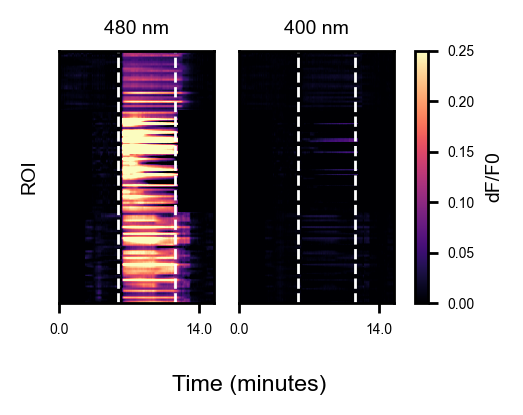

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(2.5, 2), sharey=True, sharex=True)
ax[0].imshow(dlight_traces[use_rois], **kwargs)
ax[0].set_title("480 nm")
ax[0].set_yticks([])
ax[0].set_ylabel("ROI")

h = ax[1].imshow(isos_traces[use_rois], **kwargs)
ax[1].set_title("400 nm")

for _ax in ax:
    _ax.axvline(x=max_onset, color="w", linestyle="--")
    _ax.axvline(x=max_onset + 85, color="w", linestyle="--")

    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xticklabels)

fig.supxlabel("Time (minutes)")
fig.tight_layout()
fig.colorbar(h, ax=ax.ravel(), label="dF/F0")
# savefig(fig, os.path.join(figure_cfg["store_dir"], "hek_cells_roi_responses"), bbox_inches="tight")

In [38]:
_trace = list(results.values())[2]["dlight"]["raw"][10]

In [39]:
use_region = np.concatenate([np.arange(50), np.arange(150, len(_trace))])
xvec = np.arange(len(_trace))
offset = _trace[0]

In [40]:
baseline_kwargs["maxfev"] = int(1e6)

In [41]:
params = curve_fit(
    baseline_func, use_region, _trace[use_region] - offset, **baseline_kwargs
)
fit_curve = baseline_func(xvec, *params[0]) + offset

In [42]:
setup_plotting_env()

In [43]:
from scipy.stats import pearsonr

In [44]:
x = np.nanmean(
    dlight_traces[use_rois, use_onset + use_offset : use_onset + use_duration], axis=1
)
y = np.nanmean(
    isos_traces[use_rois, use_onset + use_offset : use_onset + use_duration], axis=1
)

In [45]:
nans = np.isnan(x) | np.isnan(y)
x = x[~nans]
y = y[~nans]

In [46]:
rng = np.random.default_rng(0)

In [47]:
bootparams = []
for _boot in range(1000):
    idx = rng.choice(np.arange(len(x)), size=len(x), replace=True)
    bootparams.append(curve_fit(linear_decay, x[idx], y[idx])[0])

In [48]:
xvals = np.arange(-5, 60)

In [49]:
bootvals = []
for _params in bootparams:
    bootvals.append(linear_decay(xvals, *_params))

In [50]:
bootci = np.quantile(bootvals, [0.025, 0.975], axis=0)

In [51]:
m, b = np.mean(bootparams, axis=0)

In [52]:
mci, bci = np.std(bootparams, axis=0)

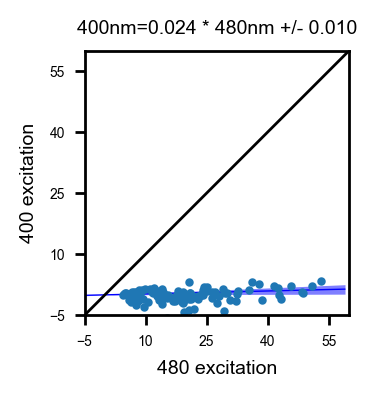

In [53]:
fig, ax = plt.subplots(1, figsize=(2, 2))
duration = 30
plt.scatter(
    dlight_traces[use_rois, use_onset + use_offset : use_onset + duration].mean(axis=1)
    * 100,
    isos_traces[use_rois, use_onset + use_offset : use_onset + duration].mean(axis=1)
    * 100,
    5,
)
ax.axis("square")
ax.set_ylim(-5, 60)
ax.set_xlim(-5, 60)
# plt.xticks(-.05, .6)
ax.set_xticks(np.arange(-5, 65, 15))
ax.set_yticks(np.arange(-5, 65, 15))
ax.set_xlabel("480 excitation")
ax.set_ylabel("400 excitation")
ax.plot(
    ax.get_xlim(),
    ax.get_ylim(),
    color=plt.rcParams["axes.edgecolor"],
    lw=1,
    zorder=-100,
)
ax.plot(xvals, np.mean(bootvals, axis=0), color="b", zorder=-150, lw=0.5)
ax.fill_between(
    xvals, bootci[1], bootci[0], color="b", alpha=0.5, zorder=-200, edgecolor=None, lw=0
)
ax.set_title(f"400nm={m:.3f} * 480nm +/- {mci:.3f}")
fig.tight_layout()
savefig(
    fig, os.path.join(figure_cfg["store_dir"], "hek_cells_scatter"), bbox_inches="tight"
)

In [54]:
clean_image = lambda x: filters.median(x, morphology.disk(3))

In [55]:
max_projs_dlight = []
max_projs_isos = []
max_projs_masks = []
for _file in files:
    raw_dat = imread(_file)
    max_projs_dlight.append(clean_image(np.max(raw_dat[1:50:2], axis=0)))
    max_projs_isos.append(clean_image(np.max(raw_dat[0:50:2], axis=0)))
    max_projs_masks.append(results[_file]["rois"] > 0)

In [56]:
cmap = sns.dark_palette([0, 1, 0], as_cmap=True)

In [57]:
kwargs = {"cmap": cmap}

In [58]:
max_projs_dlight[1].shape

(520, 688)

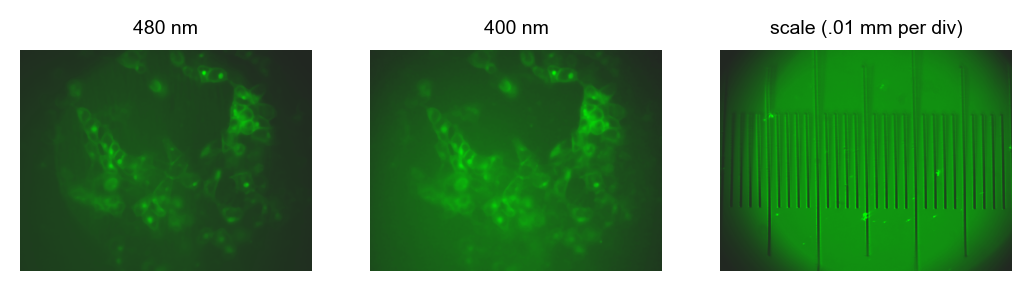

In [59]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(max_projs_dlight[1], **kwargs)
ax[0].set_title("480 nm")
ax[1].imshow(max_projs_isos[1], **kwargs)
ax[1].set_title("400 nm")
ax[2].imshow(scale_dat, **kwargs)
ax[2].set_title("scale (.01 mm per div)")
for _ax in ax:
    _ax.axis("off")
savefig(
    fig, os.path.join(figure_cfg["store_dir"], "hek_cells_fovs"), bbox_inches="tight"
)

In [60]:
from scipy.stats import zscore

In [61]:
setup_plotting_env()

In [62]:
nrois = []
for _result in results.values():
    nrois.append(len(_result["dlight"]["raw"]))

roi_file_idx = []
for i, _nrois in enumerate(nrois):
    roi_file_idx += [i] * _nrois
roi_file_idx = np.array(roi_file_idx)
nrois = np.bincount(roi_file_idx[use_rois])

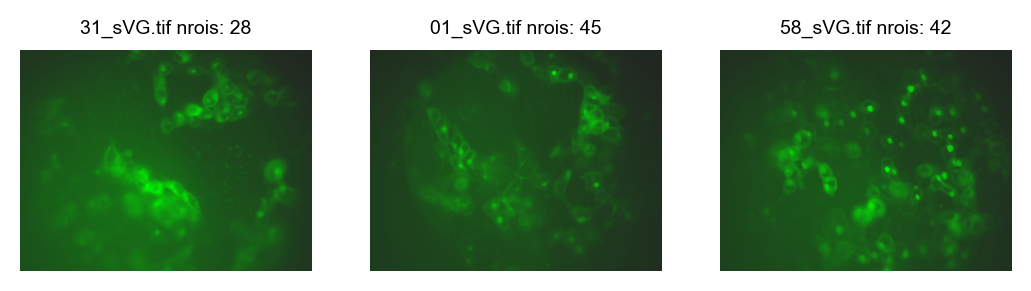

In [63]:
fig, ax = plt.subplots(1, 3)
for _file, _max_proj, _nrois, _ax in zip(files, max_projs_dlight, nrois, ax):
    _ax.imshow(_max_proj, **kwargs)
    _ax.set_title(f"{_file[-10:]} nrois: {_nrois}")
for _ax in ax:
    _ax.axis("off")

In [64]:
list(results.values())[2]["dlight"]["raw"].shape

(51, 195)

In [65]:
x = np.concatenate(
    [zscore(_[_mask].ravel()) for _, _mask in zip(max_projs_dlight, max_projs_masks)]
)
y = np.concatenate(
    [zscore(_[_mask].ravel()) for _, _mask in zip(max_projs_isos, max_projs_masks)]
)

In [66]:
nans = np.isnan(x) | np.isnan(y)
x = x[~nans]
y = y[~nans]

In [67]:
bootparams = []
for _boot in tqdm(range(1000)):
    idx = rng.choice(np.arange(len(x)), size=len(x), replace=True)
    bootparams.append(curve_fit(linear_decay, x[idx], y[idx])[0])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [68]:
xvals = np.arange(x.min(), x.max())

In [69]:
bootvals = []
for _params in bootparams:
    bootvals.append(linear_decay(xvals, *_params))

In [70]:
bootci = np.quantile(bootvals, [0.025, 0.975], axis=0)

In [71]:
m, b = np.mean(bootparams, axis=0)

In [72]:
mci, bci = np.std(bootparams, axis=0)

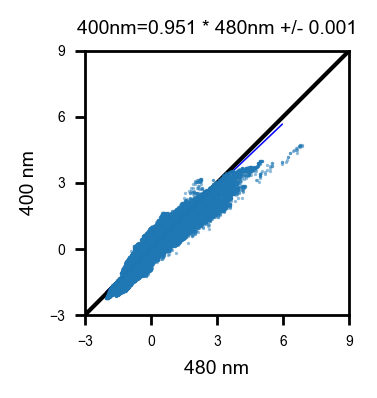

In [73]:
fig, ax = plt.subplots(1, figsize=(2, 2))
ax.scatter(x, y, 0.15, alpha=0.5, rasterized=True)
ax.axis("square")
plt.xlim(-3, 8)
plt.ylim(-3, 8)
plt.xticks(np.arange(-3, 10, 3))
plt.yticks(np.arange(-3, 10, 3))
plt.plot(
    plt.xlim(), plt.ylim(), color=plt.rcParams["axes.edgecolor"], zorder=-100, lw=1.5
)
plt.xlabel("480 nm")
plt.ylabel("400 nm")
ax.plot(xvals, np.mean(bootvals, axis=0), color="b", zorder=-150, lw=0.5)
ax.fill_between(
    xvals,
    bootci[1],
    bootci[0],
    color="b",
    alpha=0.75,
    zorder=-200,
    lw=0,
    edgecolor=None,
)
ax.set_title(f"400nm={m:.3f} * 480nm +/- {mci:.3f}")
fig.tight_layout()
savefig(
    fig,
    os.path.join(figure_cfg["store_dir"], "hek_cells_maxproj_scatter"),
    bbox_inches="tight",
    dpi=900,
)
plt.show()